In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.metrics import mean_squared_error

In [14]:
df = pd.read_csv("/kaggle/input/task-3/data.csv")
df = df.dropna()
df.describe()

,index,ranknow,open,high,low,close,volume,market,close_ratio,spread
count,1801.000000,1801.0,1801.000000,1801.000000,1801.000000,1801.000000,1.801000e+03,1.801000e+03,1801.000000,1801.0
mean,22528.000000,24.0,0.198874,0.210571,0.187127,0.199052,6.488779e+06,1.434629e+08,0.479582,0.0
std,520.048235,0.0,0.304368,0.325677,0.282491,0.304433,1.941852e+07,2.304801e+08,0.296156,0.0
min,21628.000000,24.0,0.013050,0.013350,0.012750,0.013050,0.000000e+00,1.493994e+06,0.000000,0.0
25%,22078.000000,24.0,0.030600,0.031500,0.029700,0.030600,1.368002e+05,1.858959e+07,0.218581,0.0
50%,22528.000000,24.0,0.039300,0.040950,0.037500,0.039450,4.153100e+05,2.496271e+07,0.466233,0.0
75%,22978.000000,24.0,0.270000,0.283200,0.255000,0.270000,4.879235e+06,1.955966e+08,0.746852,0.0
max,23428.000000,24.0,2.567250,2.815950,2.186550,2.563200,2.853022e+08,1.906129e+09,0.999000,0.0


In [15]:
df = df.drop(["date", "ranknow", "index"], axis=1)

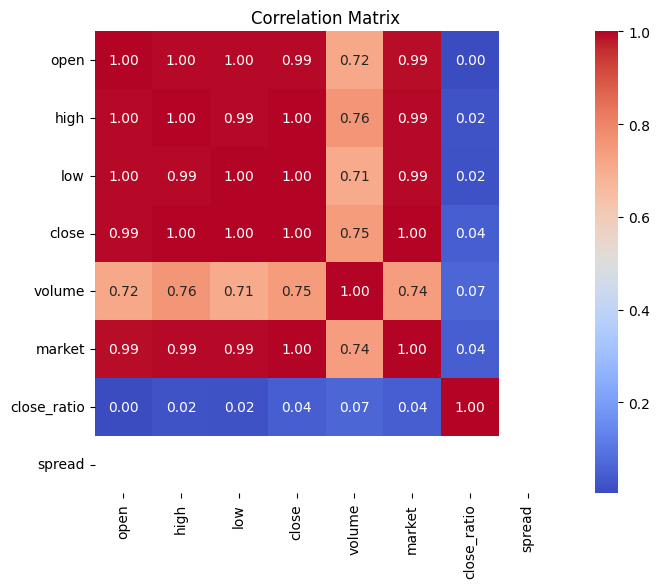

In [16]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [17]:
n_days_ahead = 10 

# Создание признаков с помощью метода скользящего окна
for i in range(1, n_days_ahead + 1):
    df[f'close_lag_{i}'] = df['close'].shift(i)
# Удаляем строки с NaN значениями (первые n_days_ahead строк)
df.dropna(inplace=True)

In [18]:
y = df['close']  
X = df.drop(['close'], axis=1)

In [19]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [20]:
# Создание и обучение модели XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0002662715184430362


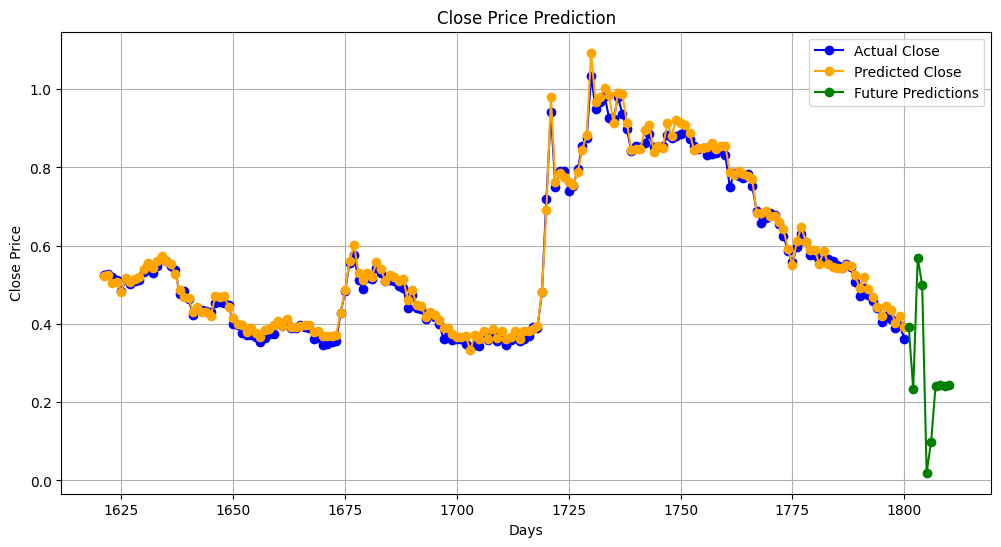

In [22]:
# Создание массива для спрогнозированных значений на 10 дней вперёд
future_preds = []
last_input = X_test.iloc[-1].values.reshape(1, -1)
for _ in range(n_days_ahead):
    pred = model.predict(last_input)[0]
    future_preds.append(pred)
    # Обновляем входные данные для следующего предсказания
    last_input = np.roll(last_input, -1)
    last_input[0, -1] = pred  # Заменяем последнее значение на предсказанное
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Close', marker='o', color='blue')
plt.plot(df.index[-len(y_test):], y_pred, label='Predicted Close', marker='o', color='orange')
plt.plot(range(df.index[-1] + 1, df.index[-1] + n_days_ahead + 1), future_preds, label='Future Predictions', marker='o', color='green')

plt.title('Close Price Prediction')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()